In [30]:
!pwd

/home/featurize/work


In [31]:
!cd CNN_food11/

In [33]:
import os

# 设定你的工作路径
work_path = '/home/featurize/work/CNN_food11/'
os.chdir(work_path)

# 验证
print("当前工作目录:", os.getcwd())

当前工作目录: /home/featurize/work/CNN_food11


In [27]:
!mv ./food11 ./CNN_food11/

In [45]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import os # 导入 os 模块
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

def quick_observe(train_dir_root):
    """
    快速观察训练集中的9张照片
    """
    pics_path = [os.path.join(train_dir_root, i) for i in os.listdir(train_dir_root)]
    labels = [i.split('_')[0] for i in os.listdir(train_dir_root)]
    idxs = np.arange(len(labels))
    sample_idx = np.random.choice(idxs, size=9, replace=False)
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    for idx_, i in enumerate(sample_idx):
        row = idx_ // 3
        col = idx_ % 3
        img = Image.open(pics_path[i])
        axes[row, col].imshow(img)
        c = labels[i]
        axes[row, col].set_title(f'class_{c}')
    plt.show()


def model_plot(model_class, input_tensor):
    """
    占位符函数，用于绘制模型架构。
    你可以使用 torchsummary 或 TensorBoard 的 add_graph。
    """
    print("正在绘制模型架构 (占位符)...")
    try:
        model = model_class()
        # 示例：使用 TensorBoard (需要安装 tensorboard：pip install tensorboard)
        writer = SummaryWriter('./logs')
        writer.add_graph(model, input_tensor)
        writer.close()
        print("模型图已添加到 TensorBoard。运行 'tensorboard --logdir=logs' 查看。")

    except Exception as e:
        print(f"无法绘制模型: {e}")


def trainer(train_loader, valid_loader, model, config, device):
    # 对于分类任务, 我们常用cross-entropy评估模型表现.
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # 交叉熵计算时，label范围为[0, n_classes-1]
    # 初始化优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    # 模型存储位置
    save_path = config['save_path']
    writer = SummaryWriter()
    if not os.path.isdir('models'):
        os.mkdir('models')

    n_epochs, best_loss, step, early_stop_count = config['num_epochs'], math.inf, 0, 0
    for epoch in range(n_epochs):
        model.train()
        loss_record = []
        train_accs = []
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            step += 1
            acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
            l_ = loss.detach().item()
            loss_record.append(l_)
            train_accs.append(acc.detach().item())
            train_pbar.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': f'{l_:.5f}', 'acc': f'{acc:.5f}'})

        mean_train_acc = sum(train_accs) / len(train_accs)
        mean_train_loss = sum(loss_record) / len(loss_record)
        print(f'mean_train_loss: {mean_train_loss}, mean_train_acc: {mean_train_acc}')
        writer.add_scalar('Loss/train', mean_train_loss, step)
        writer.add_scalar('ACC/train', mean_train_acc, step)
        model.eval()  # 设置模型为评估模式
        loss_record = []
        test_accs = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()

            loss_record.append(loss.item())
            test_accs.append(acc.detach().item())

        mean_valid_acc = sum(test_accs) / len(test_accs)
        mean_valid_loss = sum(loss_record) / len(loss_record)
        print(f'mean_valid_loss: {mean_valid_loss}, mean_valid_acc: {mean_valid_acc}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)
        writer.add_scalar('ACC/valid', mean_valid_acc, step)
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), save_path)  # 保存最优模型
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop_count']:
            print('\nModel is not improving, so we halt the training session.')
            return

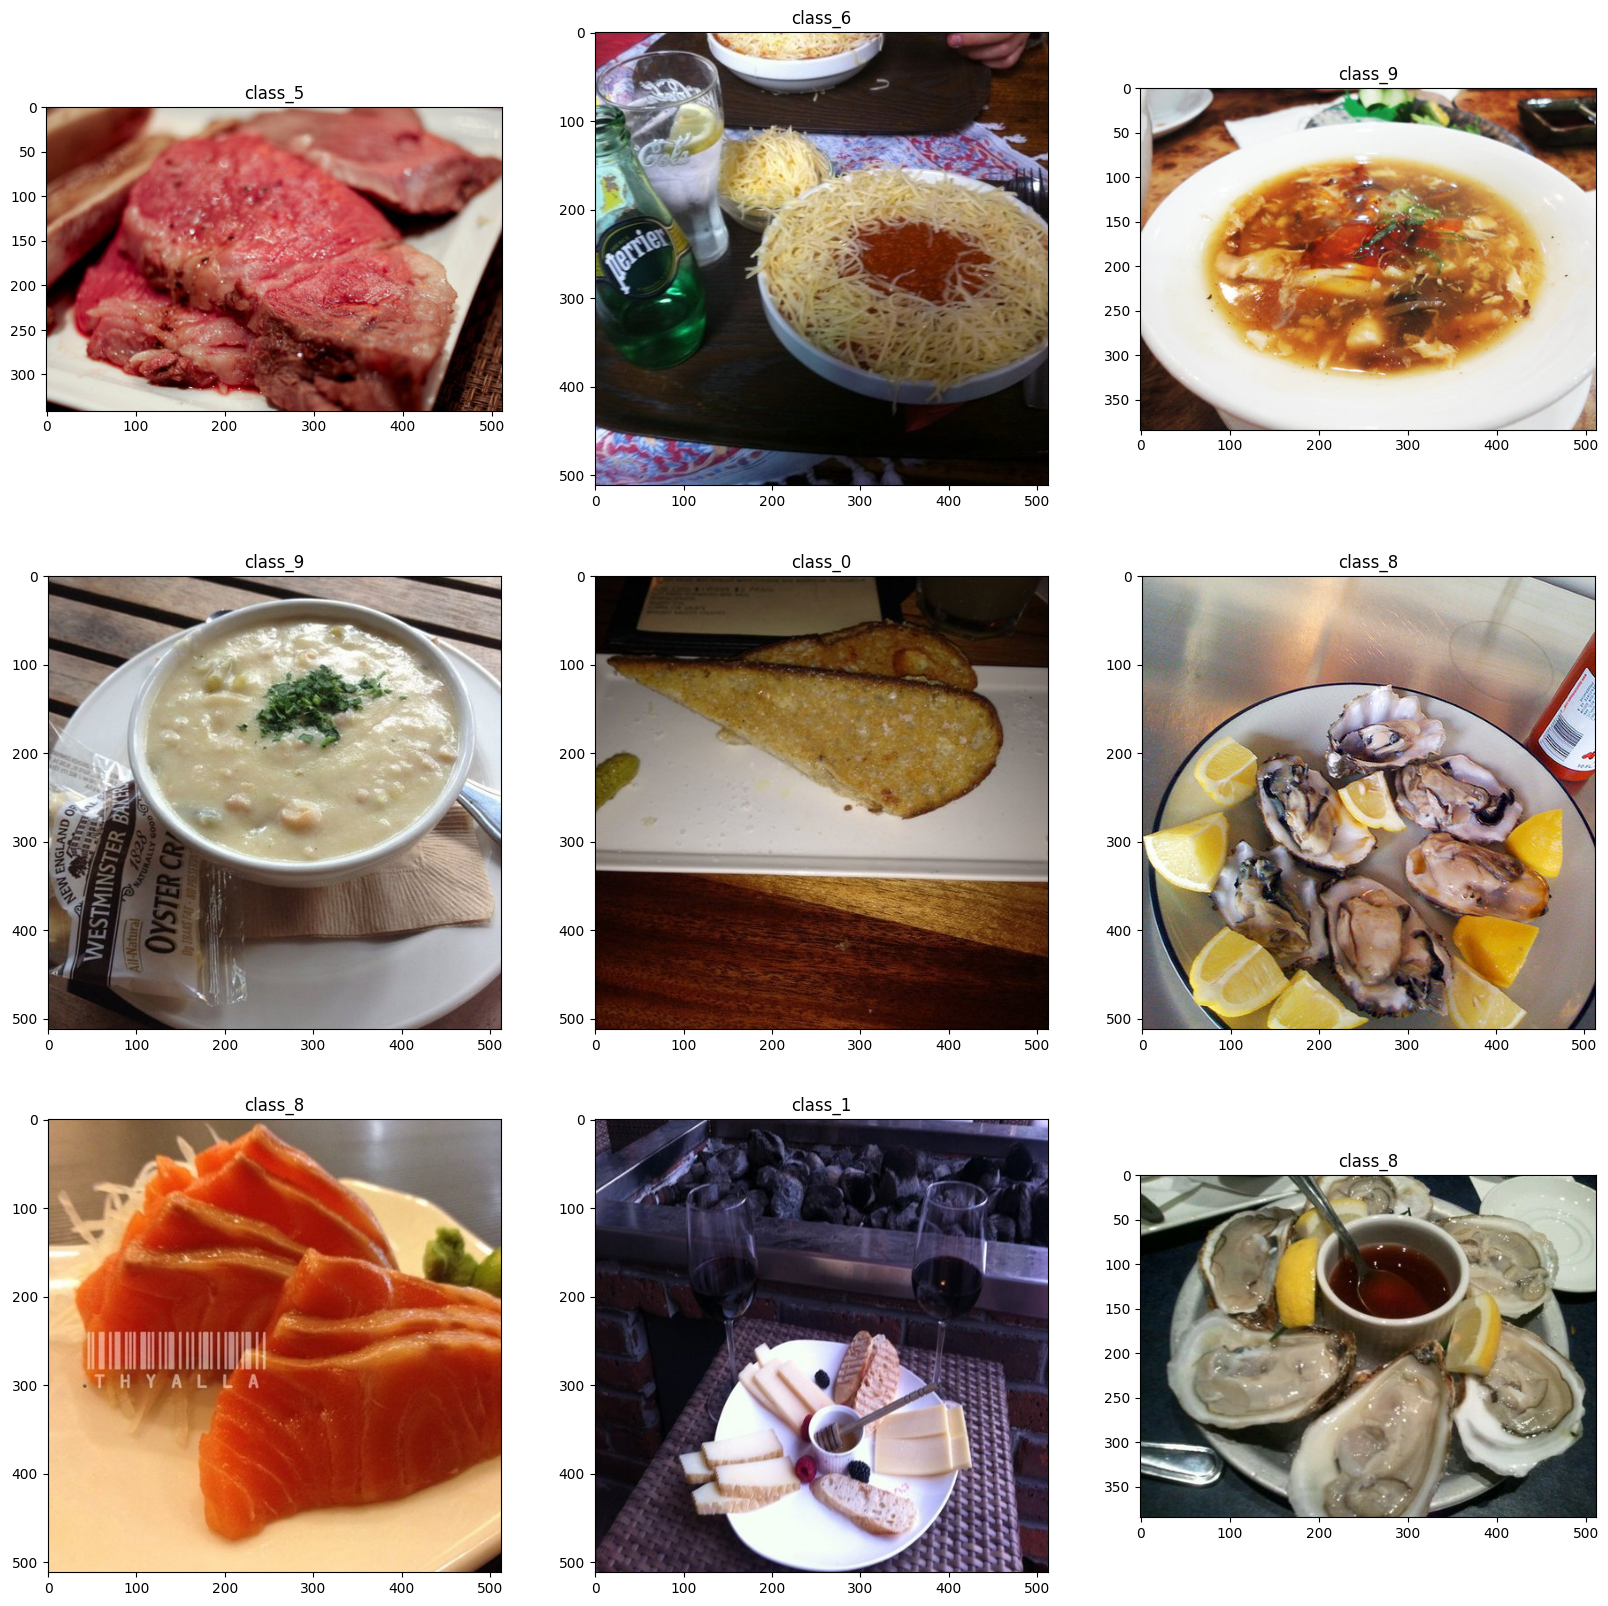

In [51]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


# 数据准备 (数据转换，数据扩增)
train_dir_root = 'food11/training'
quick_observe(train_dir_root) # 调用辅助函数观察目录

# 测试集转换：只进行缩放和转换为 Tensor
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 训练集转换：缩放、数据增强并转换为 Tensor
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    # 数据增强
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class FoodDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1  # 测试集没有label
        return im, label

In [52]:
import torch
from torch import nn
from torchvision.models import resnet50 # 导入 ResNet50
# from function import model_plot # 从 src 导入 model_plot

# ResNet50 实例 (当前未预训练)
resnet = resnet50(pretrained=False)

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(CNNBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels) #批归一化层

        )



  def forward(self, x):
        x = self.block(x)
        return x

class Residual_Network(nn.Module):
  def __init__(self):
    super(Residual_Network, self).__init__()
    self.cnn_layer1 = nn.Sequential(
        CNNBlock(3, 64, 3, 1, 1),
    )
    self.cnn_layer2 = nn.Sequential(
        CNNBlock(64, 64, 3, 1, 1),
    )

    self.cnn_layer3 = nn.Sequential(
        CNNBlock(64, 128, 3, 2, 1),
    )
    self.cnn_layer4 = nn.Sequential(
        CNNBlock(128, 128, 3, 1, 1),
    )
    self.cnn_layer5 = nn.Sequential(
        CNNBlock(128, 256, 3, 2, 1),
    )
    self.cnn_layer6 = nn.Sequential(
        CNNBlock(256, 256, 3, 1, 1),
    )

    self.fc_layer = nn.Sequential(
        nn.Linear(256*32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 11)
    )

    self.relu = nn.ReLU()

  def forward(self, x):
    x1 = self.cnn_layer1(x)
    x1 = x1.relu()

    x2 = self.cnn_layer2(x1)
    x2 += x1
    x2 = x2.relu()

    x3 = self.cnn_layer3(x2)
    x3 = x3.relu()

    x4 = self.cnn_layer4(x3)
    x4 += x3
    x4 = x4.relu()

    x5 = self.cnn_layer5(x4)
    x5 = x5.relu()

    x6 = self.cnn_layer6(x5)
    x6 += x5
    x6 = x6.relu()

    xout = x6.flatten(1) #保留 batch，展平后续维度用于全连接层输入
    xout = self.fc_layer(xout)
    return xout



In [ ]:
import os
import torch
from torch.utils.data import DataLoader

# 从各自的文件中导入模块
# from model import Classifier
# from data import FoodDataset, train_tfm, test_tfm
# from  function import trainer

# 设备配置 (优先使用 GPU，否则使用 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"正在使用设备: {device}")

# 配置字典
config = {
    'batch_size': 64,
    'num_epochs': 10,
    'early_stop_count': 200, # 注意：对于 5 个 epoch 来说，这个值非常高，可能永远不会触发早停
    'seed': 6666,
    'dataset_dir': 'food11', 
    'learning_rate': 0.0003,
    'weight_decay': 1e-5,
    'save_path': 'models/model.ckpt',


}

# --- 数据加载 ---
_dataset_dir = config['dataset_dir']

# 训练集
train_set = FoodDataset(os.path.join(_dataset_dir, 'training'), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)

# 验证集 (注意：你目前对验证集也使用了 train_tfm，这意味着包含数据增强。
# 通常，验证集和测试集只进行缩放和ToTensor，不进行数据增强，以获得更真实的性能评估。)
valid_set = FoodDataset(os.path.join(_dataset_dir, 'validation'), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True)

# 测试集 (测试集通常不打乱顺序，以便结果可复现)
test_set = FoodDataset(os.path.join(_dataset_dir, 'test'), tfm=test_tfm) # 测试集使用 test_tfm
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False)

# --- 模型初始化和训练 ---
model = Residual_Network().to(device)

# 确保模型保存目录存在
os.makedirs(os.path.dirname(config['save_path']), exist_ok=True)


# 开始训练
trainer(train_loader, valid_loader, model, config, device)

正在使用设备: cuda
One food11/training sample food11/training/0_0.jpg
One food11/validation sample food11/validation/0_0.jpg
One food11/test sample food11/test/0001.jpg


Epoch [1/10]: 100%|██████████| 155/155 [01:22<00:00,  1.88it/s, loss=2.51847, acc=0.20000]


mean_train_loss: 4.382456322639219, mean_train_acc: 0.1337500000192273
mean_valid_loss: 2.247310651673211, mean_valid_acc: 0.20346003908801963
Saving model with loss 2.247...


Epoch [2/10]: 100%|██████████| 155/155 [01:21<00:00,  1.90it/s, loss=2.36072, acc=0.20000]


mean_train_loss: 2.271558566247263, mean_train_acc: 0.17276209679342086
mean_valid_loss: 2.2063283611226967, mean_valid_acc: 0.220242446495427
Saving model with loss 2.206...


Epoch [3/10]: 100%|██████████| 155/155 [01:20<00:00,  1.92it/s, loss=2.59053, acc=0.20000]


mean_train_loss: 2.2584575391584827, mean_train_acc: 0.19997983872890474
mean_valid_loss: 2.143743841736405, mean_valid_acc: 0.24888827982876036
Saving model with loss 2.144...


Epoch [4/10]: 100%|██████████| 155/155 [01:21<00:00,  1.90it/s, loss=2.31350, acc=0.20000]


mean_train_loss: 2.215567721090009, mean_train_acc: 0.2180241935676144
mean_valid_loss: 2.1151324687180697, mean_valid_acc: 0.26567068723616777
Saving model with loss 2.115...


Epoch [5/10]: 100%|██████████| 155/155 [01:26<00:00,  1.80it/s, loss=1.95817, acc=0.20000]


mean_train_loss: 2.1800221150921235, mean_train_acc: 0.22568548389019505
mean_valid_loss: 2.0886933075057135, mean_valid_acc: 0.267117446495427
Saving model with loss 2.089...


Epoch [6/10]: 100%|██████████| 155/155 [01:23<00:00,  1.87it/s, loss=2.04866, acc=0.20000]


mean_train_loss: 2.1572203120877664, mean_train_acc: 0.24070564518051762
mean_valid_loss: 2.1170694673502886, mean_valid_acc: 0.2681682504437588


Epoch [7/10]: 100%|██████████| 155/155 [01:22<00:00,  1.87it/s, loss=1.79870, acc=0.30000]


mean_train_loss: 2.12015948910867, mean_train_acc: 0.24790322588336083
mean_valid_loss: 2.05713199906879, mean_valid_acc: 0.27077241711042543
Saving model with loss 2.057...


Epoch [8/10]: 100%|██████████| 155/155 [01:21<00:00,  1.91it/s, loss=2.02101, acc=0.30000]


mean_train_loss: 2.1018718973282846, mean_train_acc: 0.2619153226575544
mean_valid_loss: 1.9919141840051722, mean_valid_acc: 0.29171235390283445
Saving model with loss 1.992...


Epoch [9/10]: 100%|██████████| 155/155 [01:20<00:00,  1.93it/s, loss=1.91536, acc=0.20000]


mean_train_loss: 2.0793781711209203, mean_train_acc: 0.2661088709869692
mean_valid_loss: 2.0102004033547862, mean_valid_acc: 0.3036976119986287


Epoch [10/10]:  95%|█████████▌| 148/155 [01:17<00:03,  1.99it/s, loss=2.02347, acc=0.23438]